# Evaluación de Métricas y Calidad de Datos Sintéticos

Este cuaderno evalúa la calidad de los datos generados por la GAN comparando su distribución con los datos reales.
Utilizaremos técnicas de reducción de dimensionalidad (PCA y t-SNE) para visualizar si las secuencias sintéticas se asemejan a las reales.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sys
import os

# Añadir el directorio raíz al path para importar módulos src
sys.path.append(os.path.abspath('..'))

from src.data_loader import download_data
from src.preprocessing import DataPreprocessor, create_sequences

## 1. Carga de Datos y Modelo

Cargamos los datos reales para tener una referencia y el modelo generador entrenado.

In [2]:
# Configuración
TICKER = 'AAPL'
START_DATE = '2015-01-01'
END_DATE = '2025-11-29'
SEQ_LEN = 24
NOISE_DIM = 10
HIDDEN_DIM = 32
FEATURE_DIM = 1
DATA_DIR = '../data/raw'
MODEL_PATH = '../models/generator_final.pth'

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Cargar datos reales (para comparación)
csv_filename = f"{TICKER}_{START_DATE}_{END_DATE}.csv"
csv_path = os.path.join(DATA_DIR, csv_filename)

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path, header=0, skiprows=[1, 2], index_col=0, parse_dates=True)
else:
    df = download_data(TICKER, START_DATE, END_DATE, save_dir=DATA_DIR)

# Preprocesar
preprocessor = DataPreprocessor()
data_scaled = preprocessor.fit_transform(df, ['Close'])
real_sequences = create_sequences(data_scaled, SEQ_LEN)

# Seleccionar 500 muestras reales aleatorias para la visualización
indices = np.random.choice(len(real_sequences), 500, replace=False)
real_samples = real_sequences[indices].squeeze() # (500, 24)

print(f"Muestras reales seleccionadas: {real_samples.shape}")

Muestras reales seleccionadas: (500, 24)


In [4]:
# 2. Definir y Cargar el Generador
class Generator(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.linear(lstm_out)
        return self.sigmoid(output)

generator = Generator(input_dim=NOISE_DIM, hidden_dim=HIDDEN_DIM, output_dim=FEATURE_DIM).to(device)

try:
    generator.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    print("Modelo cargado exitosamente.")
except FileNotFoundError:
    print(f"Error: No se encontró el modelo en {MODEL_PATH}. Asegúrate de haber ejecutado el notebook de entrenamiento.")

Modelo cargado exitosamente.


## 2. Generación de Datos Sintéticos

Generamos 500 nuevas secuencias sintéticas usando ruido aleatorio.

In [5]:
num_samples = 500
generator.eval()

with torch.no_grad():
    # Generar ruido
    z = torch.randn(num_samples, SEQ_LEN, NOISE_DIM).to(device)
    # Generar secuencias
    synthetic_data = generator(z).cpu().numpy().squeeze() # (500, 24)

print(f"Muestras sintéticas generadas: {synthetic_data.shape}")

Muestras sintéticas generadas: (500, 24)


## 3. Visualización PCA (Análisis de Componentes Principales)

Reducimos la dimensionalidad de las secuencias (de 24 pasos de tiempo a 2 componentes principales) para visualizar su distribución en un plano 2D.

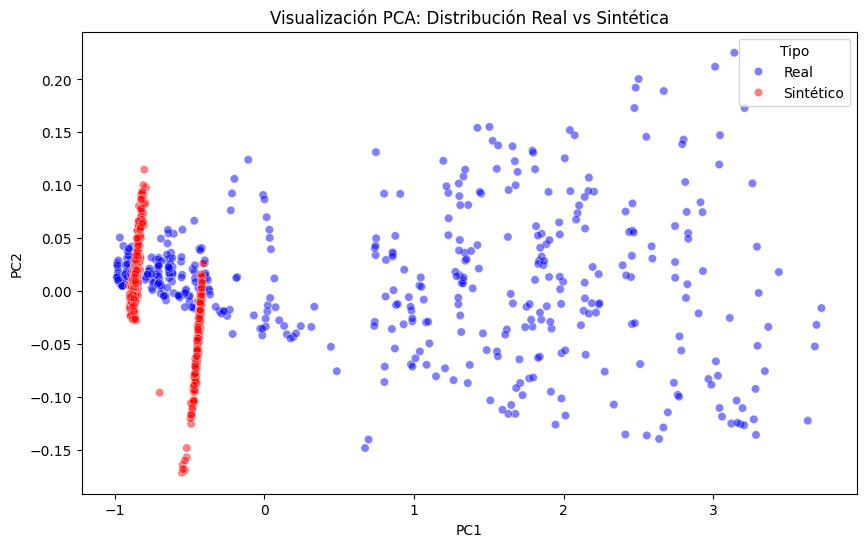

In [6]:
# Preparar datos para PCA
# Concatenamos reales y sintéticos
combined_data = np.concatenate([real_samples, synthetic_data], axis=0)
labels = np.array(['Real'] * num_samples + ['Sintético'] * num_samples)

# Aplicar PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(combined_data)

# Crear DataFrame para graficar
df_pca = pd.DataFrame({
    'PC1': pca_results[:, 0],
    'PC2': pca_results[:, 1],
    'Tipo': labels
})

# Graficar
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Tipo', alpha=0.5, palette={'Real': 'blue', 'Sintético': 'red'})
plt.title('Visualización PCA: Distribución Real vs Sintética')
plt.show()

## 4. Visualización t-SNE (t-Distributed Stochastic Neighbor Embedding)

t-SNE es una técnica no lineal que suele ser mejor para preservar la estructura local de los datos y visualizar clusters complejos.

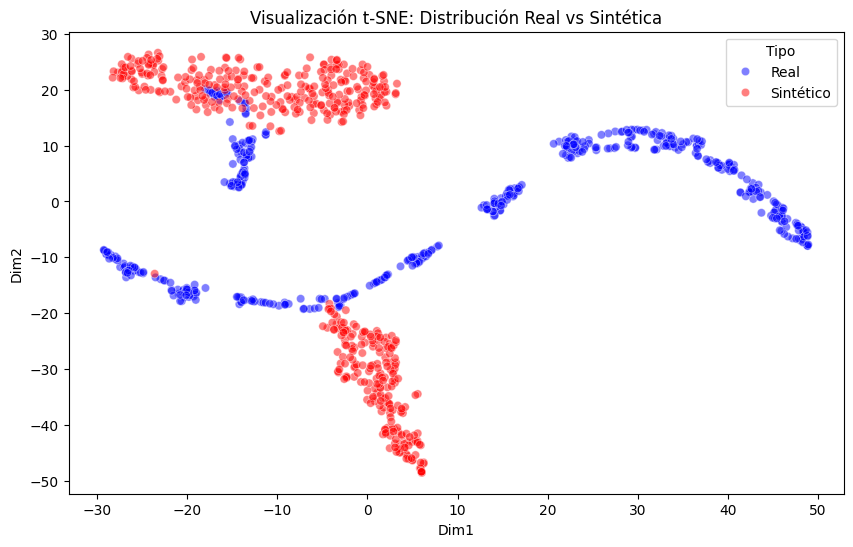

In [8]:
# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tsne_results = tsne.fit_transform(combined_data)

# Crear DataFrame para graficar
df_tsne = pd.DataFrame({
    'Dim1': tsne_results[:, 0],
    'Dim2': tsne_results[:, 1],
    'Tipo': labels
})

# Graficar
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_tsne, x='Dim1', y='Dim2', hue='Tipo', alpha=0.5, palette={'Real': 'blue', 'Sintético': 'red'})
plt.title('Visualización t-SNE: Distribución Real vs Sintética')
plt.show()

## 5. Interpretación de Resultados

**¿Qué deberíamos ver?**

*   **Excelente Calidad:** Si los puntos rojos (Sintéticos) y azules (Reales) forman una sola nube mezclada y superpuesta, significa que el modelo ha aprendido bien la distribución subyacente de los datos. Es difícil distinguir visualmente una secuencia real de una falsa.
*   **Mala Calidad / Overfitting:** Si los puntos están separados en "islas" o clusters distintos (e.g., una nube azul a un lado y una roja al otro), el modelo no ha logrado capturar la variabilidad real o ha colapsado en un modo (Mode Collapse).